## Normal Distribution



Measurement Probabilities:
  State |00100000>: 0.3820
  State |00001000>: 0.3740
  State |00000010>: 0.1200
  State |10000000>: 0.1240


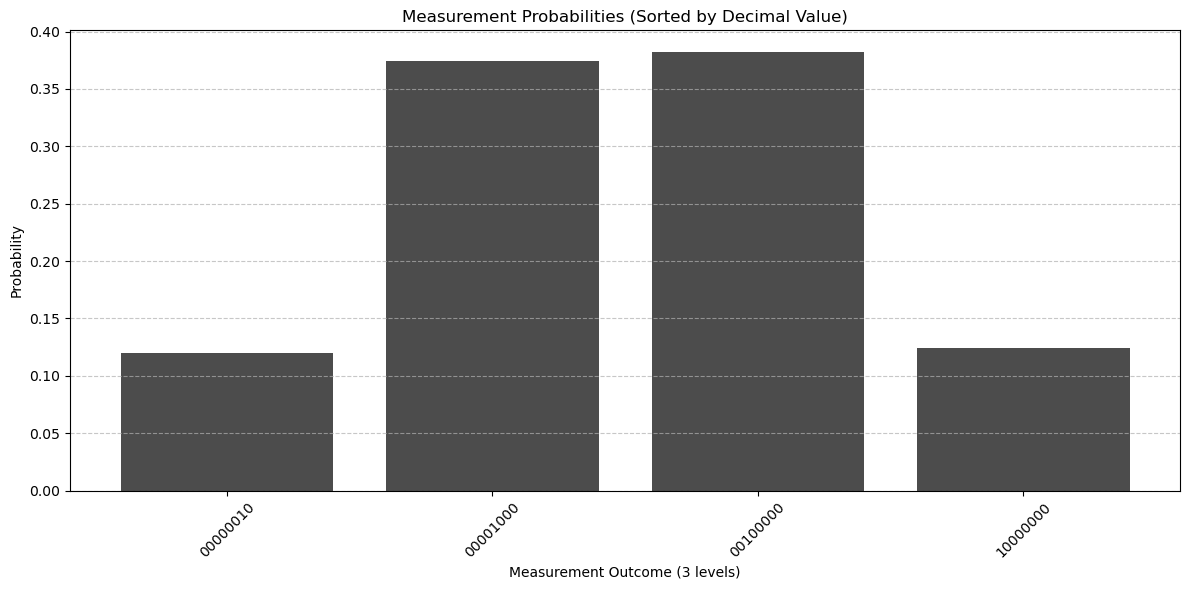

In [14]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import numpy as np


def build_exponential_distribution_circuit(num_qubits: int) -> QuantumCircuit:
    """
    Builds the quantum circuit with custom gate operations that emulate a normal distribution.
    """
    q = QuantumRegister(num_qubits, 'q')
    c = ClassicalRegister(num_qubits, 'c')
    qc = QuantumCircuit(q, c)

    # Initialize the central qubit (impulse at the center)
    qc.x(q[num_qubits // 2])

    # Gate operations creating the effect of exponential probability spread
    for block in range(1, num_qubits // 2):
        qc.reset(q[0])        # Ancilla reset
        qc.h(q[0])            # Hadamard for superposition

        for op in range(1, 2 * block + 1):
            left = q[num_qubits // 2 - block + op - 1]
            right = q[num_qubits // 2 - block + op]

            qc.cswap(q[0], left, right)

            if op != 2 * block:
                qc.cx(right, q[0])

    # Add measurements to every other qubit (odd index)
    for i in range(1, num_qubits, 2):
        qc.measure(q[i], c[i])

    return qc


def run_simulation(qc: QuantumCircuit, shots: int = 1000):
    """
    Runs the quantum simulation and returns the result counts.
    """
    simulator = AerSimulator()
    compiled = transpile(qc, simulator)
    job = simulator.run(compiled, shots=shots)
    result = job.result()
    return result.get_counts(qc)


def calculate_probabilities(counts: dict) -> dict:
    """
    Converts raw measurement counts into probabilities.
    """
    total_shots = sum(counts.values())
    return {state: count / total_shots for state, count in counts.items()}


def plot_probabilities(probabilities: dict, num_qubits: int):
    """
    Plots the sorted probability distribution from simulation results.
    """
    if not probabilities:
        print("No measurement outcomes to plot.")
        return

    # Sort by decimal value for clearer visualization
    sorted_states = sorted(probabilities.keys(), key=lambda x: int(x, 2))
    sorted_probs = [probabilities[state] for state in sorted_states]

    plt.figure(figsize=(12, 6))
    plt.bar(sorted_states, sorted_probs, color='black', alpha=0.7)
    plt.xlabel(f"Measurement Outcome ({num_qubits // 2 - 1} levels)")
    plt.ylabel("Probability")
    plt.title("Measurement Probabilities (Sorted by Decimal Value)")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


def main(num_qubits=18, shots=1000):
    """
    Main execution function to simulate and plot the quantum exponential distribution.
    """
    qc = build_exponential_distribution_circuit(num_qubits)
    counts = run_simulation(qc, shots)
    probabilities = calculate_probabilities(counts)

    print("\nMeasurement Probabilities:")
    for state, prob in probabilities.items():
        print(f"  State |{state}>: {prob:.4f}")

    plot_probabilities(probabilities, num_qubits)


if __name__ == "__main__":
    main(num_qubits=8, shots=1000)
